In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

In [3]:
!pip install --upgrade plotly
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests

print(__version__) # need 1.9.0 or greater
init_notebook_mode(connected = True)


def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

    100% |████████████████████████████████| 37.8MB 699kB/s 
  Running setup.py bdist_wheel for retrying ... - done
  Stored in directory: /root/.cache/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying
  Found existing installation: plotly 1.12.12
    Uninstalling plotly-1.12.12:
      Successfully uninstalled plotly-1.12.12
3.4.2


In [4]:
df = pd.read_csv('drive/My Drive/wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [0]:
df.date = pd.to_datetime(df.date)

In [6]:
plotly_df(df.set_index('date')[['count']])

In [8]:
!pip install fbprophet
from fbprophet import Prophet

    100% |████████████████████████████████| 2.1MB 11.4MB/s 
    100% |████████████████████████████████| 50.0MB 629kB/s 
  Running setup.py bdist_wheel for fbprophet ... - \ error
  Complete output from command /usr/bin/python3 -u -c "import setuptools, tokenize;__file__='/tmp/pip-install-_2x6pdn8/fbprophet/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d /tmp/pip-wheel-341vuv9z --python-tag cp36:
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build/lib
  creating build/lib/fbprophet
  creating build/lib/fbprophet/stan_model
  Traceback (most recent call last):
    File "<string>", line 1, in <module>
    File "/tmp/pip-install-_2x6pdn8/fbprophet/setup.py", line 123, in <module>
      """
    File "/usr/local/lib/python3.6/dist-packages/setuptools/__init__.py", line 143, in setup
      return distutils.core.setup(**attrs)
    File "/usr/lib/p

In [9]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
df.tail()

,ds,y
382,2016-01-16,1644
381,2016-01-17,1836
376,2016-01-18,2983
375,2016-01-19,3389
372,2016-01-20,3559


In [0]:
# отрезаем из обучающей выборки последние 30 точек, чтобы измерить на них качество
train_df = df[:-predictions] 

In [12]:
m = Prophet()
m.fit(train_df)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

In [14]:
forecast.loc[382].yhat

3426.4985704939663

**Ответ(1) : 3426**

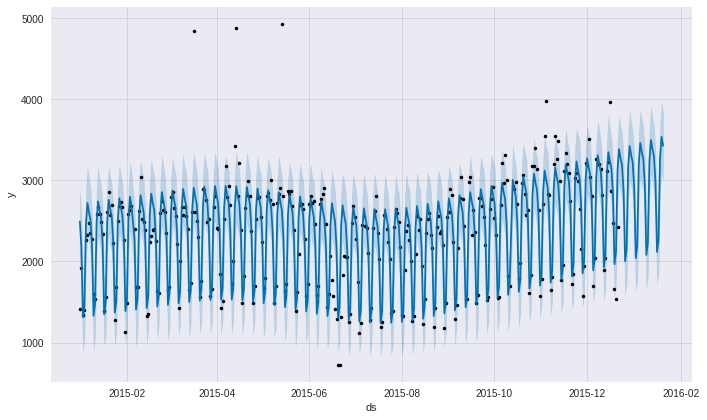

In [15]:
m.plot(forecast);

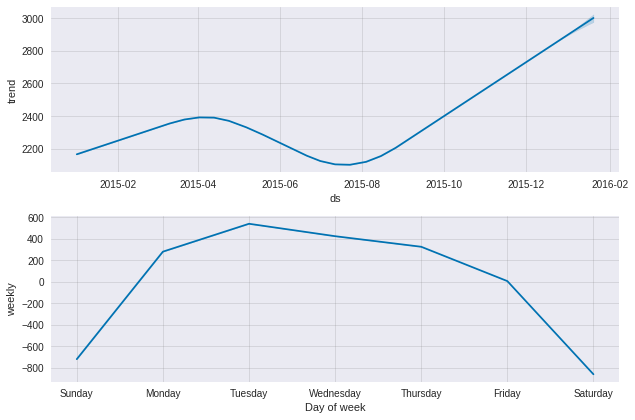

In [16]:
m.plot_components(forecast);

In [17]:
print(', '.join(forecast.columns))

ds, trend, trend_lower, trend_upper, yhat_lower, yhat_upper, additive_terms, additive_terms_lower, additive_terms_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, weekly, weekly_lower, weekly_upper, yhat


In [0]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

In [19]:
cmp_df.head()

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2015-01-01,2493.394569,2089.427337,2868.094043,1414
2015-01-02,2176.170858,1765.691191,2571.869333,1920
2015-01-03,1310.164121,899.846013,1713.337706,1338
2015-01-04,1453.891639,1046.486326,1874.608321,1404
2015-01-05,2458.694224,2027.191589,2874.007578,2264


In [20]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print ('MAPE', np.mean(abs(cmp_df[-predictions:]['p'])))
print ('MAE', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE 34.50292574049453
MAE 599.8383194732162


**Ответ(2) : MAPE  = 34.5**

**Ответ(3) : MAE  = 600**

In [0]:
from matplotlib import pyplot as plt

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

In [0]:
import statsmodels

Критерий Дики-Фуллера: p=0.015384


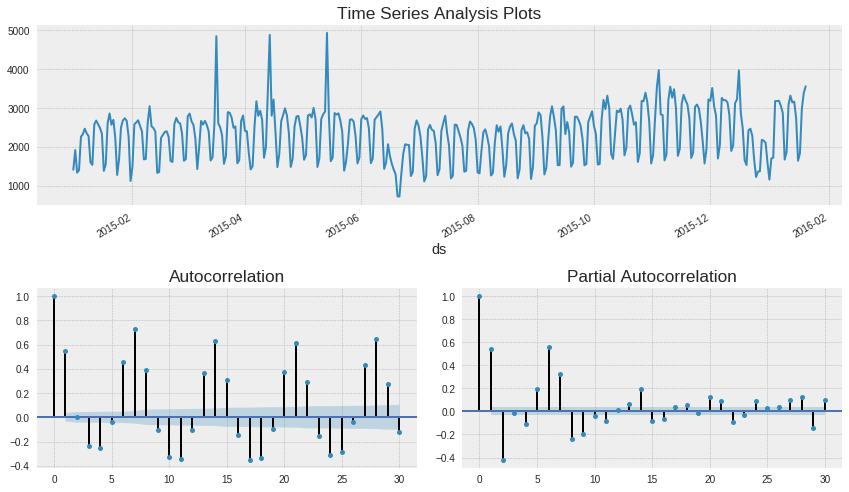

In [27]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(cmp_df.y, lags=30)

**Ответ 4: Series is not stationary**

In [28]:
ps = 1# range(0, 5)
d = [0, 1]# d=1
qs = 2# range(0, 4)
Ps = 3# range(0, 5)
D= [0, 1, 2] #D=1
Qs = [0, 1]

from itertools import product

parameters = product(d, D, Qs)
parameters_list = list(parameters)
len(parameters_list)

12

In [29]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=statsmodels.tsa.statespace.sarimax.SARIMAX(cmp_df.y, order=(ps, param[0], qs), 
                                        seasonal_order=(Ps, param[1], param[2], 1)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
# print(result_table.sort_values(by = 'aic', ascending=True).head())

CPU times: user 3.17 s, sys: 1.95 s, total: 5.12 s
Wall time: 2.71 s


In [30]:
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters          aic
1  (1, 2, 1)  6040.151008
0  (1, 2, 0)  6160.244792


**Ответ 5: D = 2, d = 1, Q = 1, q = 2, P = 3, p = 1**